In [1]:
import cv2
import numpy as np
import os
import glob
import pickle
import argparse
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Cek versi OpenCV untuk inisialisasi SIFT yang tepat
# (Agar kompatibel dengan logika sift_extractors.py Anda di berbagai versi OpenCV)
def get_sift():
    try:
        return cv2.SIFT_create()
    except AttributeError:
        return cv2.xfeatures2d.SIFT_create()

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
def imread_img(path_image):
    # Membaca gambar (default OpenCV baca sebagai BGR)
    img = cv2.imread(path_image)
    return img

def label_image(path_to_data):
    list_label = os.listdir(path_to_data)
    
    # Hindari file sistem tersembunyi (seperti .ipynb_checkpoints)
    list_label = [l for l in list_label if not l.startswith('.')]

    label2id = {}
    for id_, value in enumerate(list_label):
        label2id[value] = id_

    data_train = []
    data_label = []

    print(f"Loading data from: {path_to_data}")
    print(f"Found labels: {list_label}")

    for label in list_label:
        # Mengambil semua file dalam folder label
        # Menambahkan dukungan ekstensi umum jpg/png
        search_path = os.path.join(path_to_data, label, '*')
        files = glob.glob(search_path)
        
        print(f"Processing {label}: found {len(files)} images")
        
        for img_path in files:
            image = imread_img(img_path)
            
            # Pastikan gambar terbaca (tidak None)
            if image is not None:
                label_image = label2id[label]
                data_train.append(image)
                data_label.append(label_image)
            else:
                print(f"Warning: Could not read image {img_path}")

    return data_train, data_label, label2id

In [23]:
def extract_sift_features(list_image):
    image_descriptors = []
    sift = get_sift() # Menggunakan fungsi helper agar kompatibel
    
    print("Extracting SIFT features...")
    for i, image in enumerate(list_image):
        # Konversi ke grayscale biasanya lebih baik untuk SIFT, 
        # tapi kita ikuti kode asli yang menerima input langsung
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        _, descriptor = sift.detectAndCompute(gray, None)
        image_descriptors.append(descriptor)
        
    return image_descriptors

def kmean_bow(all_descriptors, num_cluster):
    bow_dict = []
    
    print(f"Running K-Means clustering with k={num_cluster}...")
    kmeans = MiniBatchKMeans(
        n_clusters=num_cluster,
        batch_size=5000,
        max_iter=300,
        random_state=42,
        verbose=1
    )
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    # Menyimpan dictionary vocabulary jika belum ada
    if not os.path.isfile('bow_dictionary.pkl'):
        pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))
        print("Saved bow_dictionary.pkl")

    return bow_dict

def create_feature_bow(image_descriptors, BoW, num_cluster):
    X_features = []

    print("Creating BoW histograms...")
    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            # Menghitung jarak antara deskriptor gambar dengan vocabulary BoW
            distance = cdist(image_descriptors[i], BoW)
            
            # Mencari cluster terdekat
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        
            # Normalisasi histogram agar tidak bias oleh jumlah keypoint
            features = features / np.linalg.norm(features) if np.linalg.norm(features) > 0 else features
            X_features.append(features)


    return X_features

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.spatial.distance import cdist
import numpy as np
import pickle, os
import cv2
from sklearn.cluster import MiniBatchKMeans

# ================================
# KONFIGURASI
# ================================
DATASET_PATH = "data"
NUM_CLUSTER = 300          # BoW lebih besar untuk fitur lebih kaya
BOW_PATH = "bow_dictionary.pkl"
MODEL_PATH = "sift_hog_linear_svm.sav"

# ================================
# LOAD DATA
# ================================
data_train, label, label2id = label_image(DATASET_PATH)

if len(data_train) == 0:
    print("Error: dataset kosong, cek DATASET_PATH.")
else:
    print(f"Total images loaded: {len(data_train)}")

    # ================================
    # EKSTRAK SIFT
    # ================================
    image_descriptors = extract_sift_features(data_train)

    # Kumpulkan semua descriptor untuk K-Means
    all_descriptors = []
    for d in image_descriptors:
        if d is not None:
            all_descriptors.extend(d)

    all_descriptors = np.array(all_descriptors)
    print(f"Total SIFT descriptors: {all_descriptors.shape[0]}")

    # ================================
    # BUILD / LOAD BoW DICTIONARY
    # ================================
    rebuild_bow = True
    if os.path.isfile(BOW_PATH):
        BoW = pickle.load(open(BOW_PATH, "rb"))
        # cek apakah jumlah cluster sama
        if BoW.shape[0] == NUM_CLUSTER:
            print("Using existing BoW dictionary.")
            rebuild_bow = False
        else:
            print("Existing BoW has different cluster size, rebuilding...")

    if rebuild_bow:
        if all_descriptors.shape[0] < NUM_CLUSTER:
            NUM_CLUSTER = max(30, all_descriptors.shape[0] // 2)
            print(f"Not enough descriptors, adjusting NUM_CLUSTER to {NUM_CLUSTER}")
        BoW = kmean_bow(all_descriptors, NUM_CLUSTER)
        pickle.dump(BoW, open(BOW_PATH, "wb"))
        print(f"BoW dictionary saved to {BOW_PATH}")

    # ================================
    # BANGUN HISTOGRAM BoW (NORMALIZED)
    # ================================
    print("Building normalized BoW histograms...")
    X_bow = []
    for desc in image_descriptors:
        hist = np.zeros(NUM_CLUSTER, dtype=np.float32)

        if desc is not None:
            dist = cdist(desc, BoW)
            nearest = np.argmin(dist, axis=1)
            for idx in nearest:
                hist[idx] += 1

        # normalisasi L2
        norm = np.linalg.norm(hist)
        if norm > 0:
            hist = hist / norm

        X_bow.append(hist)

    X_bow = np.array(X_bow)
    print("BoW feature shape:", X_bow.shape)

    # ================================
    # EKSTRAK HOG
    # ================================
    print("Extracting HOG features...")
    hog_list = []
    for img in data_train:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resized = cv2.resize(gray, (128, 64))  # konsisten
        feat = hog(
            gray_resized,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            feature_vector=True,
            channel_axis=None
        )
        hog_list.append(feat)

    X_hog = np.array(hog_list)
    print("HOG feature shape:", X_hog.shape)

    # ================================
    # GABUNGKAN SIFT-BoW + HOG
    # ================================
    X_combined = np.hstack([X_bow, X_hog])
    y = np.array(label)
    print("Combined feature shape:", X_combined.shape)

    # ================================
    # TRAIN / VAL SPLIT
    # ================================
    X_train, X_val, y_train, y_val = train_test_split(
        X_combined, y, test_size=0.2, stratify=y, random_state=42
    )

    # ================================
    # PIPELINE + GRIDSEARCH LinearSVM
    # ================================
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVC(class_weight='balanced', max_iter=5000))
    ])

    param_grid = {
        'svm__C': [0.1, 0.5, 1, 2, 5, 10],
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    print("Training LinearSVM (SIFT-BoW + HOG)...")
    grid.fit(X_train, y_train)

    print("\nBest Params:", grid.best_params_)
    print("Train Accuracy    : {:.2f}%".format(grid.score(X_train, y_train) * 100))
    print("Validation Accuracy: {:.2f}%".format(grid.score(X_val, y_val) * 100))

    # ================================
    # SAVE MODEL
    # ================================
    pickle.dump(grid.best_estimator_, open(MODEL_PATH, "wb"))
    print(f"\nModel saved to {MODEL_PATH}")
    print("Label Mapping:", label2id)


Loading data from: data
Found labels: ['bus', 'car', 'moto', 'pedestrian', 'truck']
Processing bus: found 194 images
Processing car: found 554 images
Processing moto: found 425 images
Processing pedestrian: found 319 images
Processing truck: found 312 images
Total images loaded: 1804
Extracting SIFT features...
Total SIFT descriptors: 166385
Existing BoW has different cluster size, rebuilding...
Running K-Means clustering with k=300...
Init 1/1 with method k-means++
Inertia for init 1/1: 1576419968.0
Minibatch step 1/9983: mean batch inertia: 104957.9456
Minibatch step 2/9983: mean batch inertia: 78999.4048, ewa inertia: 78999.4048
Minibatch step 3/9983: mean batch inertia: 76280.384, ewa inertia: 78835.98835871287
Minibatch step 4/9983: mean batch inertia: 75660.3584, ewa inertia: 78645.12915428985
Minibatch step 5/9983: mean batch inertia: 75794.8224, ewa inertia: 78473.82226823636
Minibatch step 6/9983: mean batch inertia: 74276.5504, ewa inertia: 78221.5611484164
Minibatch step 7/9

🚀 Memulai Evaluasi pada 'test_data'...
Loading data from: test_data
Found labels: ['bus', 'car', 'moto', 'pedestrian', 'truck']
Processing bus: found 10 images
Processing car: found 10 images
Processing moto: found 10 images
Processing pedestrian: found 10 images
Processing truck: found 10 images
✅ Berhasil memuat 50 gambar test.
⏳ Mengekstraksi fitur SIFT...
Extracting SIFT features...
⏳ Loading BoW dictionary...
⏳ Membangun histogram BoW...
BoW test shape: (50, 300)
⏳ Mengekstraksi HOG fitur...
HOG test shape: (50, 3780)
Final test feature shape: (50, 4080)
⏳ Loading trained model...
⏳ Prediksi model...

🏆 Accuracy Test: 98.00%

--- Classification Report ---
              precision    recall  f1-score   support

         bus       1.00      1.00      1.00        10
         car       1.00      1.00      1.00        10
        moto       1.00      0.90      0.95        10
  pedestrian       0.91      1.00      0.95        10
       truck       1.00      1.00      1.00        10

    a

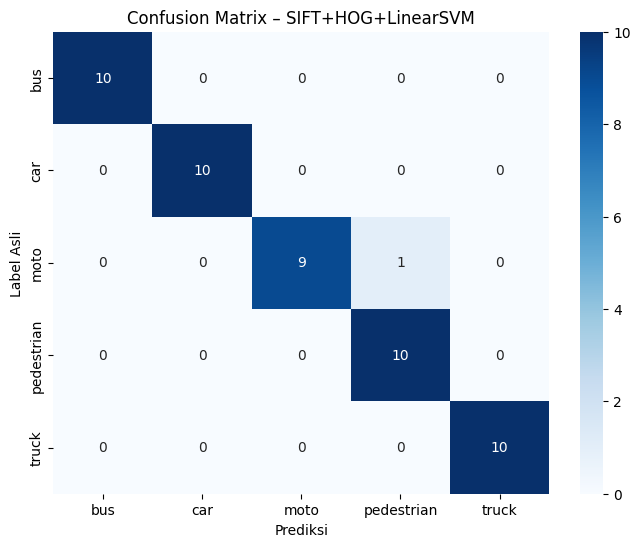

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import cv2

TEST_PATH = "test_data"

print(f"🚀 Memulai Evaluasi pada '{TEST_PATH}'...")

# ================================
# 1. Load test images
# ================================
test_images, test_labels, _ = label_image(TEST_PATH)

if len(test_images) == 0:
    print("⚠️ Error: Tidak ada gambar dalam test_data")
    raise SystemExit()

print(f"✅ Berhasil memuat {len(test_images)} gambar test.")

# ================================
# 2. Ekstraksi SIFT descriptor
# ================================
print("⏳ Mengekstraksi fitur SIFT...")
test_descriptors = extract_sift_features(test_images)

# ================================
# 3. Load BoW dictionary
# ================================
print("⏳ Loading BoW dictionary...")
BoW = pickle.load(open("bow_dictionary.pkl", "rb"))
NUM_CLUSTER = BoW.shape[0]

# ================================
# 4. Bangun histogram BoW (NORMALIZED)
# ================================
print("⏳ Membangun histogram BoW...")
X_bow_test = []

for desc in test_descriptors:
    hist = np.zeros(NUM_CLUSTER)

    if desc is not None:
        dist = cdist(desc, BoW)
        nearest = np.argmin(dist, axis=1)
        for idx in nearest:
            hist[idx] += 1

    # normalisasi
    norm = np.linalg.norm(hist)
    if norm > 0:
        hist = hist / norm

    X_bow_test.append(hist)

X_bow_test = np.array(X_bow_test)

print("BoW test shape:", X_bow_test.shape)

# ================================
# 5. Ekstraksi HOG feature
# ================================
print("⏳ Mengekstraksi HOG fitur...")
hog_list = []

for img in test_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_resized = cv2.resize(gray, (128, 64))

    feat = hog(
        gray_resized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True,
        channel_axis=None
    )
    hog_list.append(feat)

X_hog_test = np.array(hog_list)
print("HOG test shape:", X_hog_test.shape)

# ================================
# 6. Gabungkan SIFT-BoW + HOG
# ================================
X_test_final = np.hstack([X_bow_test, X_hog_test])
print("Final test feature shape:", X_test_final.shape)

# ================================
# 7. Load trained model
# ================================
print("⏳ Loading trained model...")
model = pickle.load(open("sift_hog_linear_svm.sav", "rb"))

# ================================
# 8. Predict
# ================================
print("⏳ Prediksi model...")
y_pred = model.predict(X_test_final)

# ================================
# 9. Evaluasi
# ================================
accuracy = accuracy_score(test_labels, y_pred)
print(f"\n🏆 Accuracy Test: {accuracy * 100:.2f}%")

target_names = [name for name, _id in sorted(label2id.items(), key=lambda x: x[1])]

print("\n--- Classification Report ---")
print(classification_report(test_labels, y_pred, target_names=target_names))

# ================================
# 10. Confusion Matrix
# ================================
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Prediksi")
plt.ylabel("Label Asli")
plt.title("Confusion Matrix – SIFT+HOG+LinearSVM")
plt.show()
